In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os
from sklearn.neural_network import MLPRegressor

In [2]:
seed = 792 #random seed
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
#read data
df = pd.read_csv('kerma_data.txt', sep='\t')
X = df[['Energy (keV)', 'Breast Thickness (cm)', 'Compression-Distance(cm)']].values
Y = df[['Kerma(mGy/hist)', 'Error(mGy/Hist)']].values
standard_scaler = preprocessing.StandardScaler()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=True, random_state=seed)
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)
minimum = np.min(y_train[:,0])
y_train[:,0] = y_train[:,0]/minimum
y_train[:,1] = y_train[:,1]/minimum
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

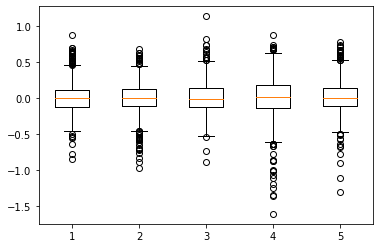

In [4]:
model_vec = []
error_vec = []
for train_index, test_index in kf.split(X_train):
    X_train1, X_test1 = X_train[train_index], X_train[test_index]
    y_train1, y_test1 = y_train[train_index], y_train[test_index]
    
    max_iter = 1000
    tolerance = 0.00001

    
    model = MLPRegressor(hidden_layer_sizes=(20,20), activation='tanh', solver='lbfgs', alpha=0.00001, 
                         max_iter=max_iter, random_state=seed, tol=tolerance, 
                         verbose=True, validation_fraction=0.1)
    
    
    y_train_noise = np.random.normal(y_train1[:,0], y_train1[:,1])
    
    
    
    model.fit(X_train1, y_train_noise)
        
            

    model_vec.append(model)
    
    

    
    y = (model.predict(X_test1))
    y = np.ravel(y)
    error = 100*(y- y_test1[:,0])/y_test1[:,0]
    error_vec.append(error)



plt.boxplot(error_vec)
plt.show()
np.save('error_vec_kerma_training', error_vec)

(837,)


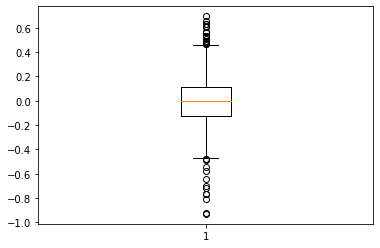

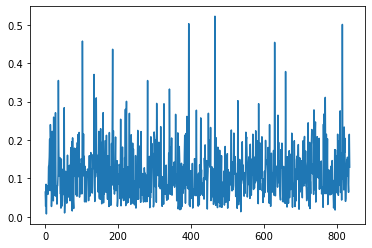

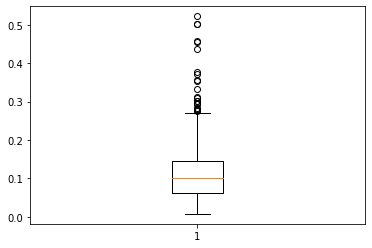

In [5]:
y_test = y_test
y_predict_vec = []
for model in model_vec:
    y_predict = model.predict(X_test)
    y_predict = y_predict*minimum
    y_predict_vec.append(y_predict)
y_mean = np.mean(y_predict_vec, axis=0)
y_std = np.std(y_predict_vec, axis=0, ddof=1)
y_mean = np.ravel(y_mean)
y_std = np.ravel(y_std)
dif = 100*(y_mean-y_test[:,0])/y_test[:,0]
print(dif.shape)

plt.boxplot([dif])
plt.show()
plt.plot(100*y_std/y_mean)
plt.show()
plt.boxplot(100*y_std/y_mean)
plt.show()

1.0000837492638406 -6.521317664836386e-17 0.9999940142014387


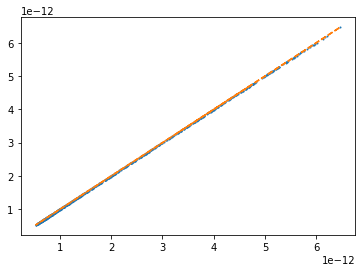

In [6]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test[:,0],y_mean)
print(slope, intercept, r_value**2)

plt.plot(y_test[:,0], y_mean, 'o', ms=1)
plt.plot(y_test[:,0], y_test[:,0], ls='--')
plt.show()

In [7]:
import pickle
for idx, model in enumerate(model_vec):
    with open("trained_model/model_kerma_trained"+str(idx)+'.pkl', 'wb') as file:
        pickle.dump(model, file)
        file.close()
    

In [8]:
with open("trained_model/min_max_kerma.pkl", 'wb') as file:
    pickle.dump(standard_scaler, file)
    file.close()

In [9]:
np.mean(np.abs(dif))

0.15947069339858905

In [10]:
np.save('y_validation', y_test)
np.save('y_predicted', y_mean)

In [11]:
np.savetxt('trained_model/minimum.txt', [minimum])